In [1]:
!python3 -m pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.12.0-py3-none-any.whl

  Using cached https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.12.0-py3-none-any.whl
  Found existing installation: tensorflow 0.12.0
    Uninstalling tensorflow-0.12.0:
      Successfully uninstalled tensorflow-0.12.0


In [29]:
!pip3 install --upgrade keras==2.1.3

    100% |████████████████████████████████| 327kB 4.5MB/s ta 0:00:01
  Found existing installation: Keras 2.0.8
    Uninstalling Keras-2.0.8:
      Successfully uninstalled Keras-2.0.8


In [23]:
!pip tensorflow --update

ERROR: unknown command "tensorflow"


In [27]:
import tensorflow as tf
import keras

print(tf.VERSION)

0.12.0


In [45]:
import os 
import numpy as np 
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Dropout, Lambda
from keras import optimizers
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore", category=UserWarning)

In [31]:
import zipfile as zf
files = zf.ZipFile("bee_imgs.zip", 'r')
files.extractall('/Users/ge/Bee photos/')
files.close()

In [32]:
import pandas as pd
import sys
import random
import gc
import warnings
import imageio
import skimage
import skimage.io
import skimage.transform
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow

img_folder='/Users/ge/Bee photos/bee_imgs/'
img_width=100
img_height=100
img_channels=3

np.random.seed(42)
tensorflow.set_random_seed(2)

In [47]:
bees=pd.read_csv('/Users/ge/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

def read_or_skip(file):
    """This function is to supress imageio exception if file doesn't exist"""
    try:
        img = skimage.io.imread(img_folder + file)
        img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
        return img[:,:,:img_channels]
    except:
        #print('Skipping %s. %s' %(file, sys.exc_info()[1]))
        return None

bees['img'] = bees['file'].apply(read_or_skip)
bees.dropna(inplace=True)

plt.style.use('seaborn')

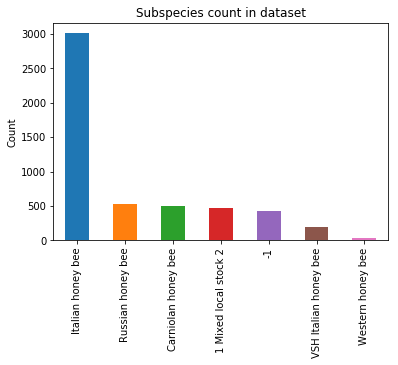

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [7]:
bees.subspecies.value_counts().plot.bar(title="Subspecies count in dataset")
plt.ylabel("Count")
plt.show()
bees.subspecies.value_counts()

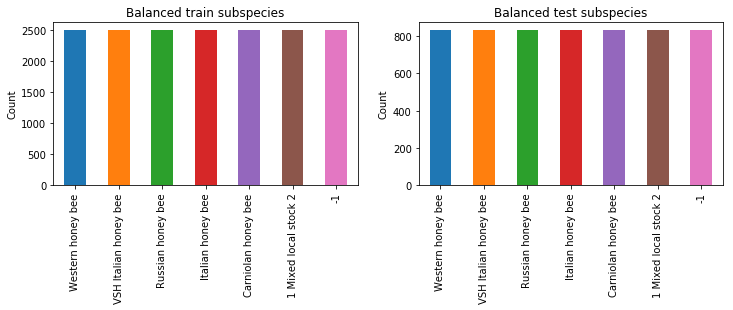

6513

In [34]:
train_bees_unbalanced, test_bees_unbalanced, _train_labels_unbalanced, _test_labels_unbalanced = train_test_split(bees, bees.subspecies)

ss_names = train_bees_unbalanced.subspecies.values.unique() 
ss_num = ss_names.size
# Total rows in rebalanced dataset. Can be lower or higher than original data rows.
n_samples = bees.size / 2
ratio = 0.25

# Train/test rows nums
test_num = n_samples * ratio
train_num = n_samples - test_num

# Resample each subspecies category and add to resulting train dataframe
train_bees_balanced = pd.DataFrame()
test_bees_balanced = pd.DataFrame()
for ss in ss_names:
    # Resample category in train bees
    bees_cur = train_bees_unbalanced[train_bees_unbalanced.subspecies == ss]
    bees_cur_resampled = resample(bees_cur, n_samples=int(train_num/ss_num))
    train_bees_balanced = pd.concat([train_bees_balanced, bees_cur_resampled])
    # Resample category in test bees
    bees_cur = test_bees_unbalanced[test_bees_unbalanced.subspecies == ss]
    bees_cur_resampled = resample(bees_cur, n_samples=int(test_num/ss_num))
    test_bees_balanced = pd.concat([test_bees_balanced, bees_cur_resampled])

# 3. Extract features and labels from balanced train, test

# Get train features and labels from train rebalanced bees
train_labels = pd.get_dummies(train_bees_balanced.subspecies)
train_data=np.stack(train_bees_balanced.img)

# Get test features and one hot encoded labels from balanced test
test_labels = pd.get_dummies(test_bees_balanced.subspecies)
test_data = np.stack(test_bees_balanced.img)
    

# Plot resampled data to check
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
train_bees_balanced.subspecies.value_counts().plot.bar(title ="Balanced train subspecies", ax=ax[0])
ax[0].set_ylabel("Count")
test_bees_balanced.subspecies.value_counts().plot.bar(title ="Balanced test subspecies", ax=ax[1])
ax[1].set_ylabel("Count")

plt.show()

gc.collect()

In [9]:
train_bees_balanced.columns

Index(['datetime', 'file', 'location', 'zip code', 'subspecies', 'health',
       'pollen_carrying', 'caste', 'img'],
      dtype='object')

In [ ]:
del _train_labels_unbalanced
del _test_labels_unbalanced

del train_bees_unbalanced
del test_bees_unbalanced

del train_bees_balanced
del test_bees_balanced

In [43]:
import keras.backend as K

def get_categorical_accuracy_keras(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

In [44]:
from keras import backend as K

generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
generator.fit(train_data)

# Split train data to features and labels
train_data, train_data_val, train_labels, train_labels_val = train_test_split(train_data, 
                                                                              train_labels,
                                                                              test_size=0.1)  
# Build and train CNN model
model = Sequential()
model.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(12, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(units=7))
model.add(Activation(tf.nn.softmax))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[get_categorical_accuracy_keras])

# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# Save the best model during the traning
checkpointer = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# Train
training = model.fit_generator(generator.flow(train_data,train_labels, batch_size=100),
                               epochs = 30,
                               validation_data=(train_data_val, train_labels_val),
                               steps_per_epoch=100,  # batch_size
                               callbacks=[earlystopper, checkpointer])

# Load the best model
model.load_weights('best_model.h5')

Epoch 1/30
100/100 [==============================] - 27s 275ms/step - loss: 1.3695 - get_categorical_accuracy_keras: 0.5441 - val_loss: 0.6367 - val_get_categorical_accuracy_keras: 0.7823

Epoch 00001: val_loss improved from inf to 0.63671, saving model to best_model.h5
Epoch 2/30
100/100 [==============================] - 29s 286ms/step - loss: 0.6501 - get_categorical_accuracy_keras: 0.7774 - val_loss: 1.1781 - val_get_categorical_accuracy_keras: 0.5593

Epoch 00002: val_loss did not improve from 0.63671
Epoch 3/30
100/100 [==============================] - 34s 339ms/step - loss: 0.5293 - get_categorical_accuracy_keras: 0.8181 - val_loss: 0.4044 - val_get_categorical_accuracy_keras: 0.8728

Epoch 00003: val_loss improved from 0.63671 to 0.40437, saving model to best_model.h5
Epoch 4/30
100/100 [==============================] - 30s 295ms/step - loss: 0.4334 - get_categorical_accuracy_keras: 0.8481 - val_loss: 0.4456 - val_get_categorical_accuracy_keras: 0.8308

Epoch 00004: val_loss

In [11]:
train_labels.columns.size

7